In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)
import numpy as np

import xgboost as xg
from xgboost import XGBRegressor
import lightgbm as lgb

from utils.data import  DataLoader
from utils.data import split_data, decrease_memory_occupation
from utils.metrics import calc_metrics
from utils.visulization import plot_confusion_matrix

# TODO change the dataset to unprepared version and then use categorical xgboost

In [2]:
"""
#load the data
dl = DataLoader("./config.json") # TODO load bank full later
X, y = dl.load_csv_data(filename="prepared_dataset.csv",) #  TODO load all
df = X.join(y)
decrease_memory_occupation(df);
#df.head()
"""
dl = DataLoader("./config.json")
dl.load_csv_data(filename='encoded/encoded_train_data_with_encoded_y.csv', 
                 test_filename='encoded/encoded_test_data_with_encoded_y.csv')

train_data = dl.get_data(include_target_column = True)
test_data = dl.get_test_data(include_target_column = True)
train_data.info()

loading test data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_test_data_with_encoded_y.csv
loading data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_train_data_with_encoded_y.csv
memory occupation before data type conversion: 14.71 MB
memory occupation after data type conversion: 7.49 MB
memory occupation before data type conversion: 1.6 MB
memory occupation after data type conversion: 820.71 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37068 entries, 0 to 37067
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37068 non-null  int32  
 1   campaign                       37068 non-null  int32  
 2   duration                       37068 non-null  int32  
 3   pdays                          37068 non-null  int32  
 4   previous                       37068 non-null  int32  
 5   emp.var.ra

In [3]:
# split the data
X_train, y_train = dl.get_features_and_target(train_data)
X_test, y_test = dl.get_features_and_target(test_data)

In [4]:
# TODO run with default parameters, grid search
model = XGBRegressor(max_depth = 6, min_child_weight = 10 ,subsample = 0.8 ,
                     colsample_bytree = 0.6, objective = 'reg:linear', 
                     num_estimators = 3000 , learning_rate = 0.01)


feat_names = X_train.columns.values
model.fit(X_train, y_train)

[19:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_estimators=3000,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

pricked  25  from  50  features


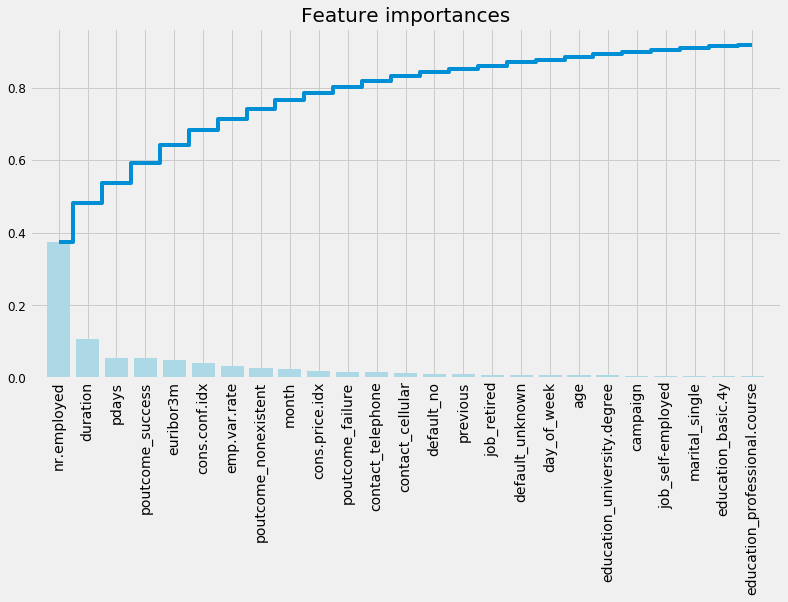

imp: [0.37335202 0.10823806 0.055131   0.05394508 0.05012872]
final score: [0.37335202 0.4815901  0.5367211  0.5906662  0.6407949 ]


In [5]:
n_pick = 0.5
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# pick first n_pick percantage of features
last_ind = int(n_pick*indices.size)
print("pricked ", last_ind, " from ", indices.size, " features")
indices = indices[0:last_ind]

plt.figure(figsize=(12,6))
plt.title("Feature importances", fontsize=20) 
plt.bar(range(len(indices)), importances[indices], color='lightblue', align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

FIGURE_OUTPUT_DIR = "./figures/results/"
plt.savefig(FIGURE_OUTPUT_DIR  + 'feature_importance_half.png', bbox_inches='tight')
plt.show();
print("imp:",importances[indices][0:5])
print("final score:", np.cumsum(importances[indices])[0:5])

In [6]:
print(feat_names[indices][0:25])

['nr.employed' 'duration' 'pdays' 'poutcome_success' 'euribor3m'
 'cons.conf.idx' 'emp.var.rate' 'poutcome_nonexistent' 'month'
 'cons.price.idx' 'poutcome_failure' 'contact_telephone'
 'contact_cellular' 'default_no' 'previous' 'job_retired'
 'default_unknown' 'day_of_week' 'age' 'education_university.degree'
 'campaign' 'job_self-employed' 'marital_single' 'education_basic.4y'
 'education_professional.course']


In [7]:
full_feature_list = ['pdays',
 'balance',
 'previous',
 'age',
 'campaign',
 'duration',
 'day',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
 'month']

# plotting pairplots

In [8]:
selected_feature_list = [
 'balance',
 'previous',
 'age',
 'duration',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
 'month']

### not all of the important features are here... proper dataset with all of the columns should be loaded for that

In [26]:
selected_feature_list = [
 'previous',
 'age',
 'duration',
 'poutcome_failure',
 'poutcome_success',
 'month']

In [23]:
dl = DataLoader("./config.json") # TODO load bank full later
dl.load_csv_data(filename='encoded/encoded_train_data.csv', 
                 test_filename='encoded/encoded_test_data.csv')

df = dl.get_data(include_target_column = True)

loading test data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_test_data.csv
loading data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_train_data.csv
memory occupation before data type conversion: 16.51 MB
memory occupation after data type conversion: 9.44 MB
memory occupation before data type conversion: 1.8 MB
memory occupation after data type conversion: 1.02 MB


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37068 entries, 0 to 37067
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37068 non-null  int32  
 1   campaign                       37068 non-null  int32  
 2   duration                       37068 non-null  int32  
 3   pdays                          37068 non-null  int32  
 4   previous                       37068 non-null  int32  
 5   emp.var.rate                   37068 non-null  float32
 6   cons.price.idx                 37068 non-null  float32
 7   cons.conf.idx                  37068 non-null  float32
 8   euribor3m                      37068 non-null  float32
 9   nr.employed                    37068 non-null  float32
 10  job_admin.                     37068 non-null  int32  
 11  job_blue-collar                37068 non-null  int32  
 12  job_entrepreneur               37068 non-null 

C:\Users\dujem\Anaconda3\envs\notebook\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


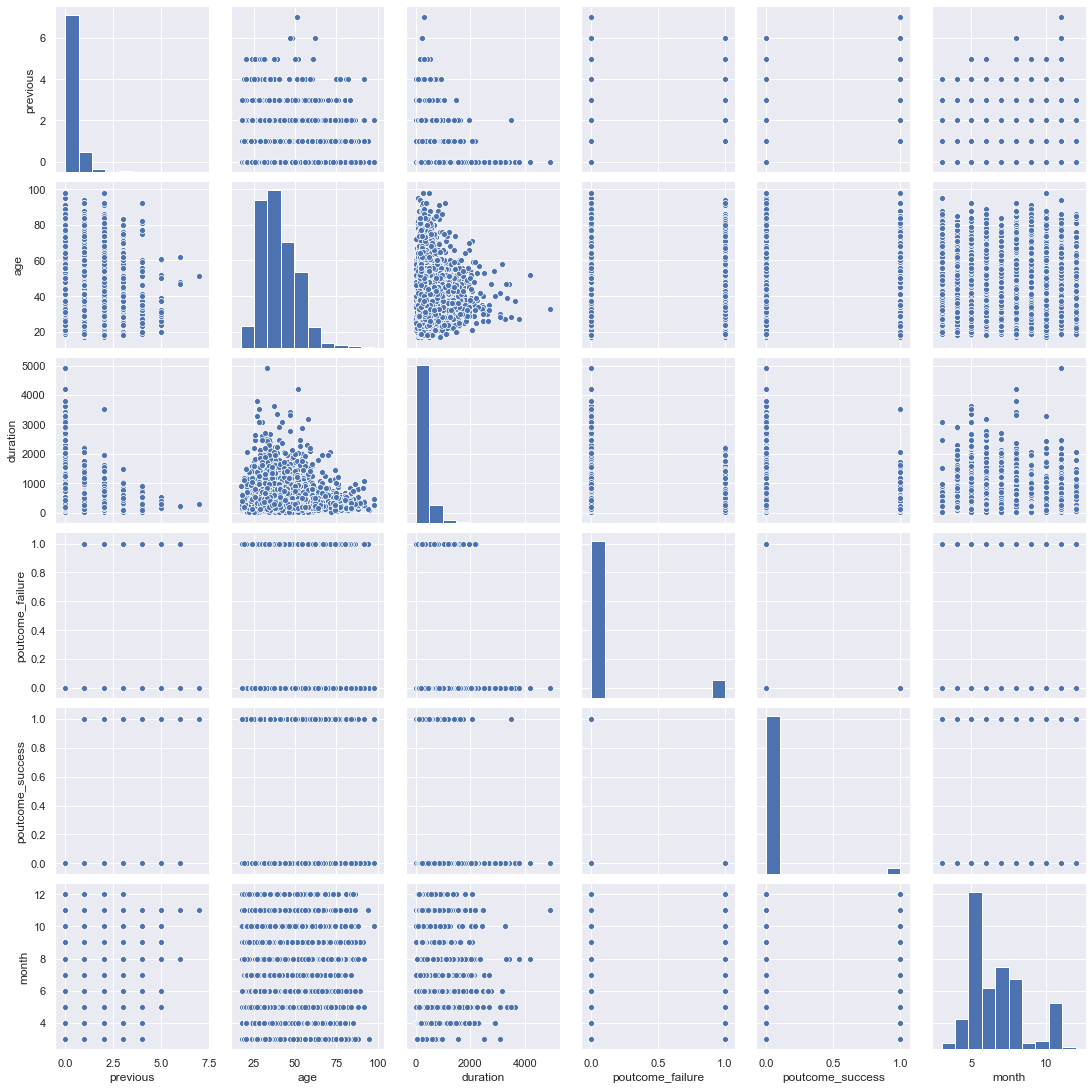

In [27]:
sns.set()
sns.pairplot(df[selected_feature_list], size = 2.5,  palette='afmhot')
plt.show();